In [58]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = ['pre_industrial', 'co2_2x']
co2_vals = [1, 2]
n_exp = len(exp_name)
ds = [xr.load_dataset(os.path.join(data_dir, exp_name[i], 'output.nc')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [5]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)
ds['ZREFHT'] = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.PS)

In [62]:
ds['P'] = cesm.get_pressure(ds.PS, ds.P0.isel(co2=0), ds.hyam.isel(co2=0), ds.hybm.isel(co2=0))
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
                                       np.atleast_1d(500 * 100)).load()
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam.isel(co2=0), ds.hybm.isel(co2=0), ds.P0.isel(co2=0),
                                       np.atleast_1d(500 * 100)).load()
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['QREFHT'] = ds.Q.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.P.isel(lev=-1)

In [7]:
ds['T500_zonal_daily_av_resize'] = ds.T500_zonal_daily_av.where(ds.time_max.dt.floor('D') == ds.time.dt.floor('D')).max(
    dim='time')

## LCL
Compare physical LCL to empirical LCL found by requiring error to dry profile less than threshold.

In [8]:
# Physical from lowest model level
ds['p_lcl'], ds['T_lcl'] = lcl_metpy(ds.T.isel(lev=-1), ds.Q.isel(lev=-1), ds.P.isel(lev=-1))

In [9]:
def find_lcl_empirical(temp_env, p_env, temp_start=None, p_start=None, temp_thresh=0.5):
    # Find LCL as the lowest pressure level where the deviation between environmental and dry profile is less than a threshold
    if temp_start is None:
        temp_start = temp_env.isel(lev=-1)
    if p_start is None:
        p_start = p_env.isel(lev=-1)
    mask = np.abs(temp_env - dry_profile_temp(temp_start, p_start, p_env)) > temp_thresh
    # Find highest pressure where deviation between t_env and t_dry is more than threshold. Then go to next highest pressure as LCL
    lcl_ind = ((mask.where(mask, other=np.nan) * np.arange(ds.lev.size)).max(dim='lev') + 1).astype(int)
    return p_env.isel(lev=lcl_ind), temp_env.isel(lev=lcl_ind)


ds['p_lcl_emp'], ds['T_at_lcl_emp'] = find_lcl_empirical(ds.T, ds.P)

In [10]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

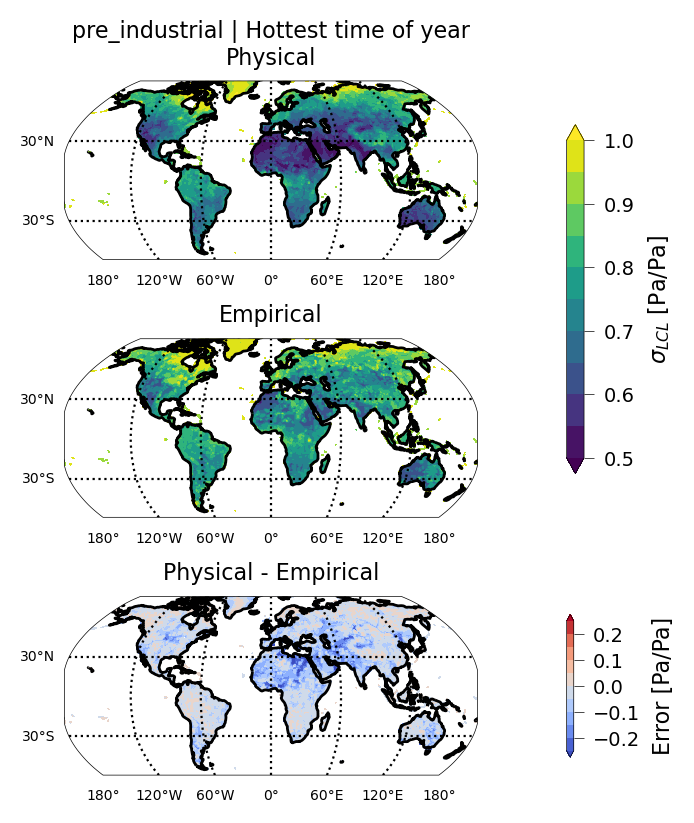

In [43]:
lat_plot_min = -60
lat_plot_max = 80

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0.5, 1.05, 0.05)
plot_contour_projection(ax[0], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1], (ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
im = plot_contour_projection(ax[2], (ds['p_lcl'] / ds.P.isel(lev=-1)).isel(co2=co2_ind) - (
        ds['p_lcl_emp'] / ds.P.isel(lev=-1)).isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-0.25, 0.3, 0.05))

ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time of year\nPhysical')
ax[1].set_title('Empirical')
ax[2].set_title('Physical - Empirical')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [Pa/Pa]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

In [11]:
def rms_lapse_profile_1d(temp: np.ndarray, z: np.ndarray, p: np.ndarray, p_lcl: float,
                         t_upper: float,
                         z_upper: float,
                         gamma_ref: float,
                         p_upper: float = 500 * 100) -> Tuple[float, float, float, float]:
    """1D helper: RMS surface-proxy from one vertical profile."""

    # Mask between LCL and >upper limit
    if p_lcl < p_upper:
        return np.nan, np.nan, np.nan, np.nan
    mask = (p <= p_lcl) & (p > p_upper)
    temp_sel = temp[mask]
    z_sel = z[mask]
    p_sel = p[mask]

    # Append exact upper limit point
    temp_sel = np.concatenate([temp_sel, [t_upper]])
    z_sel = np.concatenate([z_sel, [z_upper]])
    p_sel = np.concatenate([p_sel, [p_upper]])

    # Sort descending p (surface to top)
    order = np.argsort(-p_sel)
    temp_sel = temp_sel[order]
    z_sel = z_sel[order]
    p_sel = p_sel[order]

    # Layerwise lapse rates
    dz = np.diff(z_sel)
    dT = np.diff(temp_sel)
    gamma = -dT / dz

    # Bulk lapse rate
    DeltaZ = np.abs(z_sel[0] - z_sel[-1])

    # Variance
    dev_sq = (gamma - gamma_ref) ** 2
    numerator = np.sum(dev_sq * dz)
    try:
        ind_max_error = np.argmax(dev_sq * dz)
    except ValueError as e:
        print(e)
        print(dz)
        print(p_sel)
        print(p_lcl)
    p_max_error = p_sel[ind_max_error]
    sigma_gamma = np.sqrt(numerator / DeltaZ)
    # print(np.sqrt((dev_sq * dz)[ind_max_error]))
    frac_max_error = np.sqrt((dev_sq * dz)[ind_max_error] / numerator)

    return sigma_gamma * 1000, DeltaZ, frac_max_error, p_max_error


def rms_lapse(ds: xr.Dataset) -> xr.DataArray:
    """Apply RMS lapse function across all points in dataset.

    ds must contain DataArrays:
      - temp(lev, ...) [K]
      - z(lev, ...)    [m]
      - p(lev, ...)    [Pa or hPa]
      - t500(...), z500(...), p_lcl(...), p_s(...)
    """
    out = xr.apply_ufunc(
        rms_lapse_profile_1d,
        ds.T,
        ds.Z3,
        ds.P,
        ds.p_lcl_emp + 1e-5,
        ds.T500,
        ds.Z500,
        ds.lapse_above_lcl / 1000,
        float(ds.plev),
        input_core_dims=[['lev'], ['lev'], ['lev'], [], [], [], [], []],
        output_core_dims=[[], [], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float, float, float],
    )
    # out.name = "RMS_T_surface_proxy"
    return out

In [13]:
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.T.isel(lev=-1), ds.T_at_lcl_emp, ds.P.isel(lev=-1), ds.p_lcl_emp) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].fillna(
    lapse_dry * 1000)  # the regions where p_lcl = lowest model level, set to dry value

ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl_emp, ds.T500, ds.p_lcl_emp, float(ds.plev)) * 1000

ds['lapse_above_lcl_error'], ds['lapse_above_lcl_zrange'], ds['lapse_above_lcl_error_frac'], ds[
    'lapse_above_lcl_error_p'] = rms_lapse(ds)

In [67]:
def get_var_av(var, n_lat_av=30, mask=lsm):
    n_pad = n_lat_av // 2  # half window size
    # Pad edge with same values so can take average over latitude
    var_padded = var.where(mask).mean(dim="lon").pad(lat=(n_pad, n_pad), mode="edge")
    var_av = (var_padded.rolling(lat=n_lat_av, center=True).mean(dim="lat"))
    var_av = var_av.isel(lat=slice(n_pad, -n_pad))  # only return latitudes kept all along
    return var_av

In [187]:
mask_use = lsm.where(ds.p_lcl_emp > 550 * 100) > 0
ds['sigma_lcl_emp'] = ds['p_lcl_emp'] / ds.PREFHT
ds['sigma500'] = float(ds.plev) / ds['PREFHT']
ds['T500_zonal_daily_anom'] = ds.T500 - ds.T500_zonal_daily_av_resize
T_breakdown_av = {var: get_var_av(ds[var], mask=mask_use) for var in
                  ['T500_zonal_daily_av_resize', 'T500_zonal_daily_anom', 'p_lcl_emp', 'lapse_above_lcl',
                   'lapse_below_lcl', 'PREFHT', 'sigma_lcl_emp', 'sigma500']}
T_breakdown_av['T500'] = T_breakdown_av['T500_zonal_daily_av_resize'] + T_breakdown_av['T500_zonal_daily_anom']
# Compute average temperature from all the other average variables
T_breakdown_av['TREFHT'] = reconstruct_temp(T_breakdown_av['T500'], T_breakdown_av['PREFHT'],
                                            T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
                                            T_breakdown_av['lapse_below_lcl'] / 1000,
                                            T_breakdown_av['lapse_above_lcl'] / 1000)

T_breakdown_anom = {var: ds[var] - T_breakdown_av[var] for var in T_breakdown_av}

T_breakdown_cont = {}
T_breakdown_cont['T500_zonal_daily_av_resize'] = reconstruct_temp(
    T_breakdown_av['T500'] + T_breakdown_anom['T500_zonal_daily_av_resize'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['T500_zonal_daily_anom'] = reconstruct_temp(
    T_breakdown_av['T500'] + T_breakdown_anom['T500_zonal_daily_anom'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['sigma_lcl_emp'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    (T_breakdown_av['sigma_lcl_emp'] + T_breakdown_anom['sigma_lcl_emp']) * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['sigma500'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'] + T_breakdown_anom['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * (T_breakdown_av['PREFHT'] + T_breakdown_anom['PREFHT']), float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['lapse_below_lcl'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    (T_breakdown_av['lapse_below_lcl'] + T_breakdown_anom['lapse_below_lcl']) / 1000,
    T_breakdown_av['lapse_above_lcl'] / 1000) - T_breakdown_av['TREFHT']

T_breakdown_cont['lapse_above_lcl'] = reconstruct_temp(
    T_breakdown_av['T500'],
    T_breakdown_av['PREFHT'],
    T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['PREFHT'], float(ds.plev),
    T_breakdown_av['lapse_below_lcl'] / 1000,
    (T_breakdown_av['lapse_above_lcl'] + T_breakdown_anom['lapse_above_lcl']) / 1000) - T_breakdown_av['TREFHT']


# T_breakdown_sensitivity = {'T500_zonal_daily_av_resize': T_breakdown_av['TREFHT'] / T_breakdown_av['T500'],
#                            'T500_zonal_daily_anom': T_breakdown_av['TREFHT'] / T_breakdown_av['T500'],
#                            'lapse_below_lcl': -(T_breakdown_av['TREFHT'] * np.log(T_breakdown_av['sigma_lcl_emp'])) * R / g / 1000,
#                            'lapse_above_lcl': (T_breakdown_av['TREFHT'] * np.log(T_breakdown_av['sigma_lcl_emp'])) * R / g / 1000,
#                            'sigma_lcl_emp': R / g * ((T_breakdown_av['lapse_above_lcl'] - T_breakdown_av['lapse_below_lcl']) / 1000 / T_breakdown_av['sigma_lcl_emp'] * T_breakdown_av['TREFHT']),
#                            'sigma500': -R / g * (T_breakdown_av['lapse_above_lcl'] / 1000 / T_breakdown_av['sigma500'] * T_breakdown_av['TREFHT'])}
#
#
# T_breakdown_cont = {key: T_breakdown_anom[key] * T_breakdown_sensitivity[key]
#                               for key in T_breakdown_sensitivity}
T_anom_theory = sum(T_breakdown_cont.values()).isel(plev=0)
# T_anom_theory = sum(T_breakdown_cont.values()).isel(plev=0)

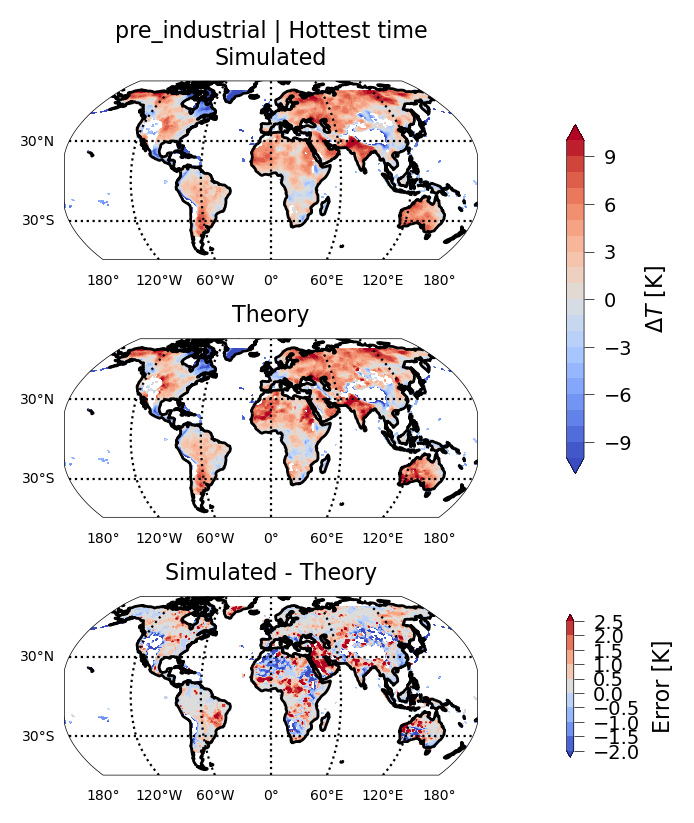

In [188]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(-10, 11, 1)
plot_contour_projection(ax[0], T_breakdown_anom['TREFHT'].isel(co2=co2_ind, plev=0),
                        cmap='coolwarm', levels=levels_use, mask=mask_use.isel(co2=co2_ind))
im = plot_contour_projection(ax[1], T_anom_theory.isel(co2=co2_ind), cmap='coolwarm', levels=levels_use,
                             mask=mask_use.isel(co2=co2_ind))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2],
                             T_breakdown_anom['TREFHT'].isel(co2=co2_ind, plev=0) - T_anom_theory.isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5), mask=mask_use.isel(co2=co2_ind))
# # im = plot_contour_projection(ax[1], var_theory,
# #                              levels=levels_temp_change[norm_by_av],
# #                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'{exp_name[co2_ind]} | Hottest time\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

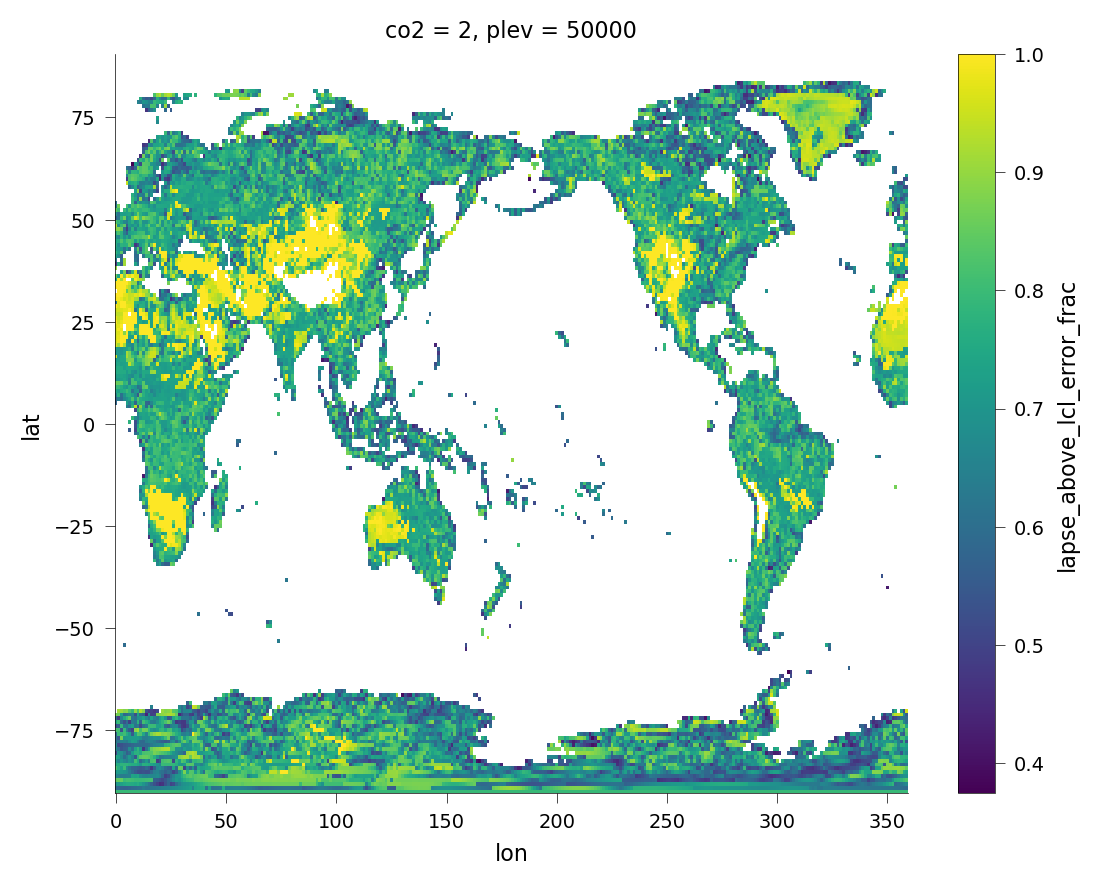

In [196]:
ds['lapse_above_lcl_error_frac'].isel(co2=1).where(lsm).plot()

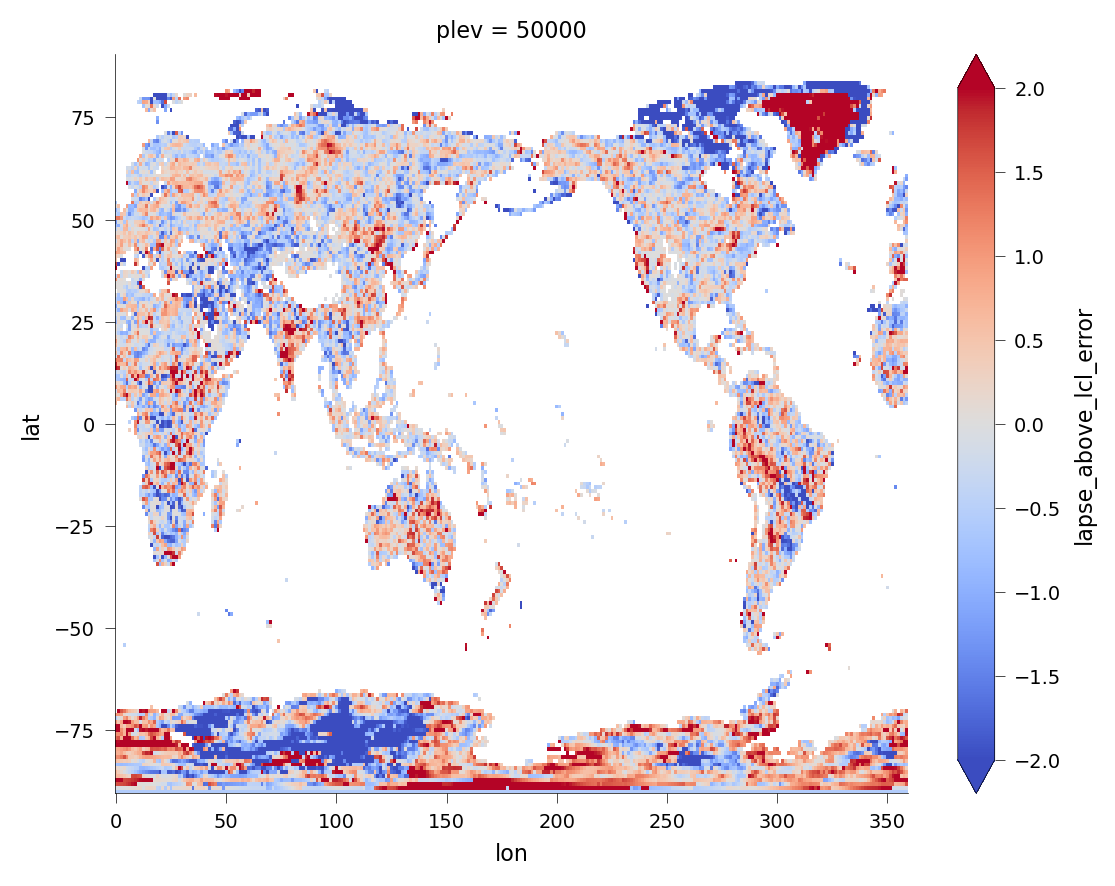

In [201]:
(ds['lapse_above_lcl_error'].isel(co2=1) - ds['lapse_above_lcl_error'].isel(co2=0)).where(lsm).plot(vmax=2, vmin=-2,
                                                                                                    cmap='coolwarm')

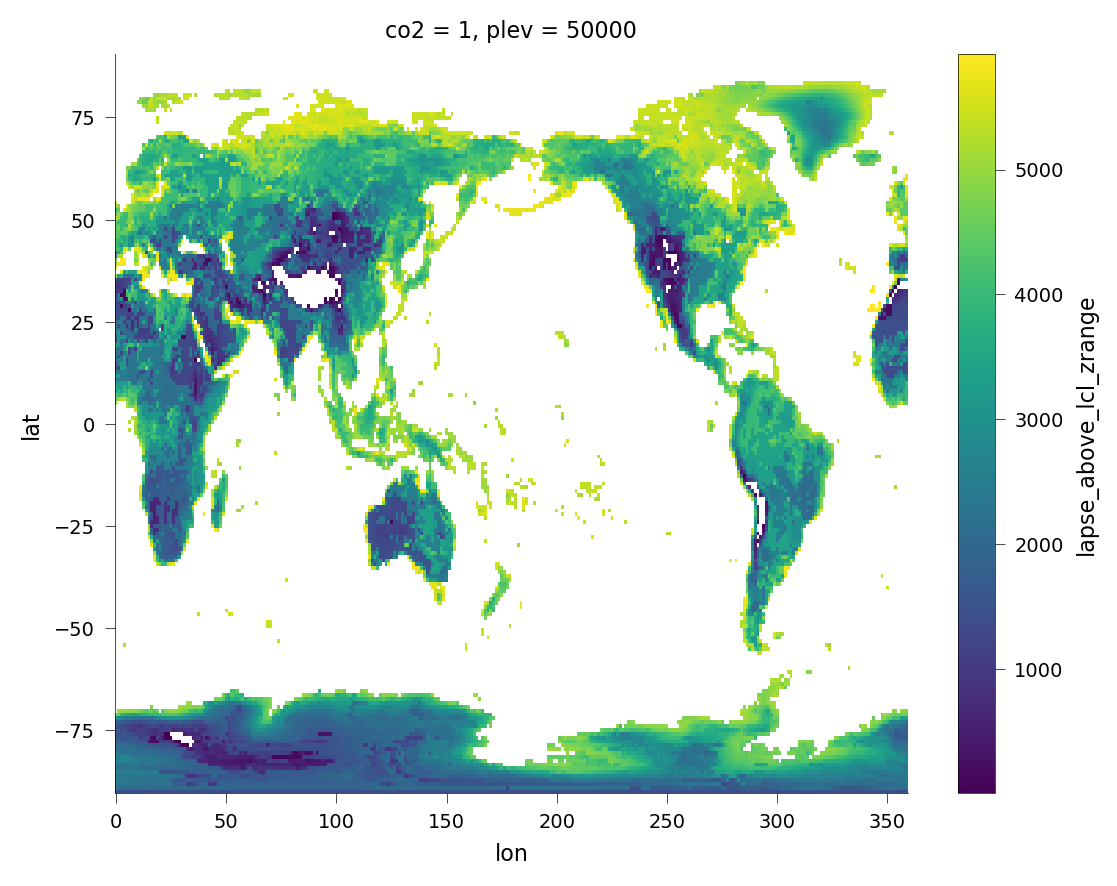

In [175]:
ds['lapse_above_lcl_zrange'].isel(co2=0).where(lsm).plot()

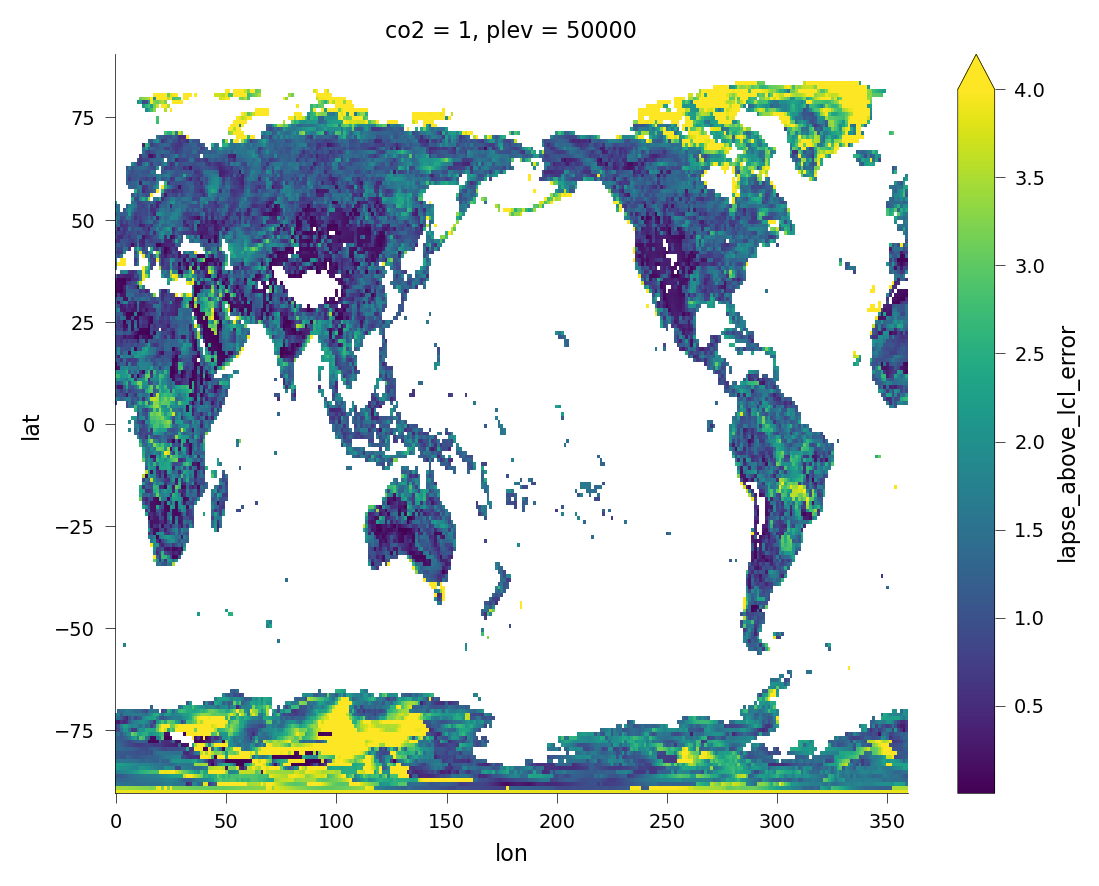

In [171]:
ds['lapse_above_lcl_error'].isel(co2=0).where(lsm).plot(vmax=4)

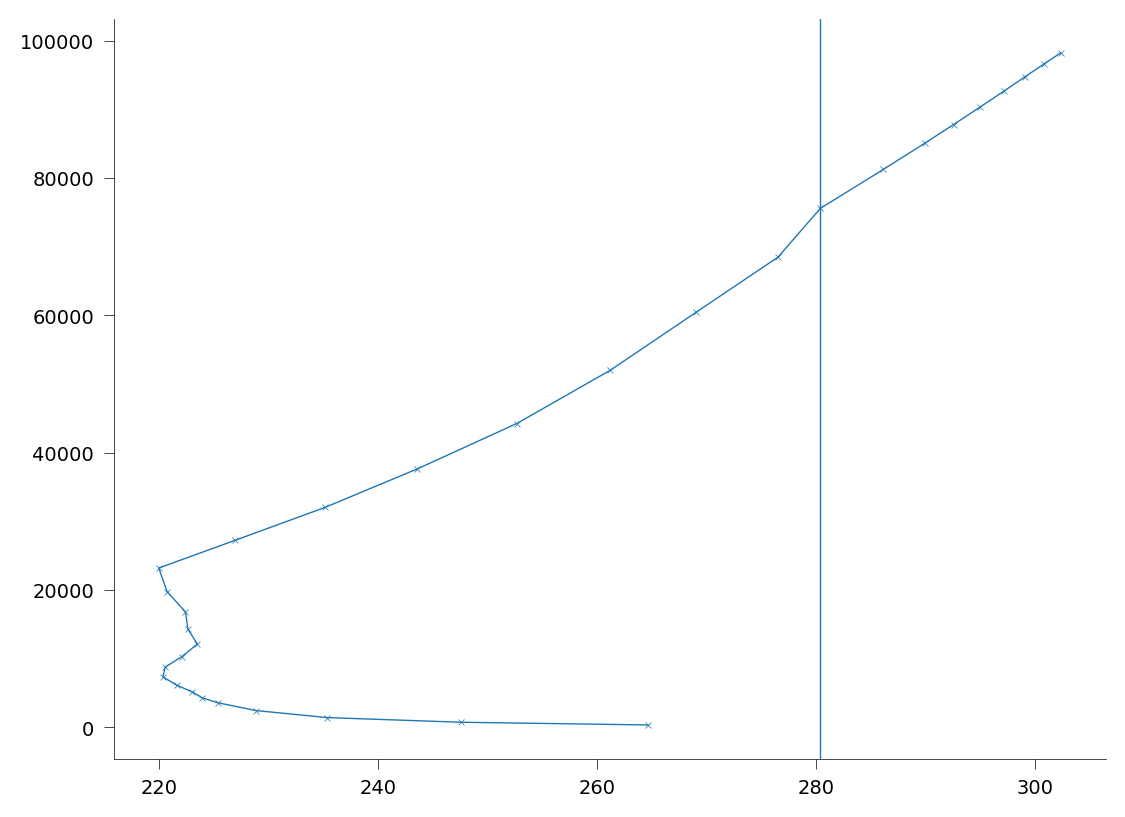

In [154]:
plt.plot(ds_use.T.isel(co2=0), ds_use.P.isel(co2=0), marker='x')
plt.axvline(ds_use.T_at_lcl_emp.isel(co2=0))

In [156]:
rms_lapse(ds_use)

[4.79867676 7.5016392  6.70462332 7.03125564]
280.41241455078125
[8.73684657 6.59559902 4.98160408 6.09436578]
286.79046630859375


(<xarray.DataArray (co2: 2, plev: 1)> Size: 16B
 array([[1.0300555],
        [1.4247017]])
 Coordinates:
     lat      float64 8B 59.84
     lon      float64 8B 50.0
   * co2      (co2) int64 16B 1 2
   * plev     (plev) int64 8B 50000,
 <xarray.DataArray (co2: 2, plev: 1)> Size: 16B
 array([[0.85024922],
        [0.7632225 ]])
 Coordinates:
     lat      float64 8B 59.84
     lon      float64 8B 50.0
   * co2      (co2) int64 16B 1 2
   * plev     (plev) int64 8B 50000,
 <xarray.DataArray (co2: 2, plev: 1)> Size: 16B
 array([[75598.59510107],
        [76299.57796739]])
 Coordinates:
     lat      float64 8B 59.84
     lon      float64 8B 50.0
   * co2      (co2) int64 16B 1 2
   * plev     (plev) int64 8B 50000)

In [99]:
apply_func_vec(rms_lapse_profile_1d, 3, ds_use.T, ds_use.Z3, ds_use.P, ds_use.p_lcl_emp, ds_use.T500, ds_use.Z500,
               ds_use.lapse_above_lcl,
               float(ds_use.plev))

ValueError: wrong number of outputs from pyfunc: expected 1, got 3

In [89]:
ds_use = ds.sel(lat=59.84, lon=50, method='nearest')
ds_use.p_lcl_emp

<xarray.DataArray 'p_lcl_emp' (co2: 2)> Size: 16B
array([75598.59510107, 76299.57796739])
Coordinates:
    lat      float64 8B 59.84
    lon      float64 8B 50.0
  * co2      (co2) int64 16B 1 2

In [74]:
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.T.isel(lev=-1), ds.T_at_lcl_emp, ds.P.isel(lev=-1), ds.p_lcl_emp) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].fillna(
    lapse_dry * 1000)  # the regions where p_lcl = lowest model level, set to dry value

ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl_emp, ds.T500, ds.p_lcl_emp, float(ds.plev)) * 1000

### Compute LCL and bulk lapse rates from average temperature profile
Below I compute the LCL, the environmental temperature at the LCL, and the bulk lapse rates above and below the LCL from the average temperature profile at each location.

In [431]:
# Compute LCL and lapse rate stuff offline from average temperature profile
exp_path_prof = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/av_profile/above_TREFHTquant'


def get_temp_profile_info(exp_ind, p_surface, p_lcl, exp_path_prof=exp_path_prof, ds_prof=None):
    # returns T_at_lcl, p_at_lcl, T
    if ds_prof is None:
        ds_prof = xr.load_dataset(f"{exp_path_prof}/T/{exp_name[exp_ind]}/output.nd2").sel(quant=quant)[['T']]
    ds_interp = interp_var_at_pressure(ds_prof, p_lcl, p_surface, hyam, hybm, p0)
    return ds_interp.T, ds_interp.plev

In [432]:
surf_model_level = -3
for i in tqdm(range(n_exp)):
    if surf_model_level is None:
        # Use actual REFHT
        ds[i]['PREFHT'] = ds[i].PS
        ds[i]['ZREFHT'] = z2m
        ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PREFHT)
        ds[i]['Z3_lcl'] = ds[i].ZREFHT + (ds[i].TREFHT - ds[i]['T_lcl']) / lapse_dry
        ds[i]['T_at_lcl'], ds[i]['p_at_lcl'] = get_temp_profile_info(i, ds[i].PS, ds[i].p_lcl)
    else:
        # Use model level as REFHT
        ds_prof = xr.merge([xr.open_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2").sel(quant=quant)[['T']],
                            xr.open_dataset(f"{exp_path_prof}/Z/{exp_name[i]}/output.nd2").sel(quant=quant)[['Z3']],
                            xr.open_dataset(f"{exp_path_prof}/Q/{exp_name[i]}/output.nd2").sel(quant=quant)[['Q']]])
        ds[i]['PREFHT'] = isca_tools.cesm.get_pressure(ds[i].PS, p0, hyam.isel(lev=surf_model_level),
                                                       hybm.isel(lev=surf_model_level))
        ds[i]['TREFHT'] = ds_prof.T.isel(lev=surf_model_level)
        ds[i]['QREFHT'] = ds_prof.Q.isel(lev=surf_model_level)
        ds[i]['ZREFHT'] = ds_prof.Z3.isel(lev=surf_model_level)

        ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PREFHT)
        ds[i]['Z3_lcl'] = ds[i].ZREFHT + (ds[i].TREFHT - ds[i]['T_lcl']) / lapse_dry

        ds[i]['T_at_lcl'], ds[i]['p_at_lcl'] = get_temp_profile_info(i, ds[i].PS, ds[i].p_lcl, ds_prof=ds_prof[['T']])
    ds[i]['lapse_below_lcl'] = get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T_at_lcl, ds[i].PREFHT, ds[i].p_at_lcl) * 1000
    ds[i]['lapse_above_lcl'] = get_bulk_lapse_rate(ds[i].T_at_lcl, ds[i].T, ds[i].p_at_lcl, float(ds[i].plev)) * 1000
    ds[i] = ds[i].load()
# Have both co2 levels in same dataset
ds = xr.concat(ds, dim=xr.DataArray([get_co2_multiplier(exp_name[i]) for i in range(n_exp)], name='co2', dims='co2'))

  0%|          | 0/2 [00:00<?, ?it/s]

## Reconstructing $T_{2m}$
First I do a sanity check that with the actual pressure, the equation reconstructs the exact $T_{2m}$.

In [8]:
show_plot = False
var = reconstruct_temp(ds.T, ds.PREFHT, ds.p_at_lcl, 500 * 100, ds.lapse_below_lcl / 1000, ds.lapse_above_lcl / 1000)
if show_plot:
    np.abs(var - ds.TREFHT).plot(vmin=0, vmax=2)
    plt.show()
print(f"{float(np.abs(var - ds.TREFHT).quantile(0.99)):.3g}")

2.16e-12


## Temperature Anomaly
Here, I breakdown what causes the hottest 5% of days to be warmer than the average over the hottest 50% of days.
### Compare theory to simulated
First, I confirm that the linear decomposition is pretty accurate.

In [10]:
TREFHT_anom_breakdown_anom = {'T500': ds.T.isel(quant=1) - ds.T.isel(quant=0),
                              'lapse_below_lcl': ds.lapse_below_lcl.isel(quant=1) - ds.lapse_below_lcl.isel(quant=0),
                              'lapse_above_lcl': ds.lapse_above_lcl.isel(quant=1) - ds.lapse_above_lcl.isel(quant=0),
                              'p_lcl': (ds.p_lcl / ds.PREFHT).isel(quant=1) - (ds.p_lcl / ds.PREFHT).isel(quant=0),
                              'p_s': (ds.plev / ds.PREFHT).isel(quant=1) - (ds.plev / ds.PREFHT).isel(quant=0)}
TREFHT_anom_breakdown_sensitivity = {'T500': (ds.TREFHT / ds.T).isel(quant=0),
                                     'lapse_below_lcl': -(ds.TREFHT * np.log(ds.p_lcl / ds.PREFHT)).isel(
                                         quant=0) * R / g / 1000,
                                     'lapse_above_lcl': (ds.TREFHT * np.log(ds.p_lcl / ds.plev)).isel(
                                         quant=0) * R / g / 1000,
                                     'p_lcl': R / g * ((
                                                               ds.lapse_above_lcl - ds.lapse_below_lcl) / 1000 * ds.PREFHT / ds.p_lcl * ds.TREFHT).isel(
                                         quant=0),
                                     'p_s': -R / g * (ds.lapse_above_lcl / 1000 * ds.PREFHT / ds.plev * ds.TREFHT).isel(
                                         quant=0)}
TREFHT_anom_breakdown_cont = {key: TREFHT_anom_breakdown_anom[key] * TREFHT_anom_breakdown_sensitivity[key]
                              for key in TREFHT_anom_breakdown_anom}
TREFHT_anom_theory = sum(TREFHT_anom_breakdown_cont.values())
TREFHT_anom = ds.TREFHT.isel(quant=1) - ds.TREFHT.isel(quant=0)

# Add T_ft breakdown
TREFHT_anom_breakdown_anom['T500_zonal_av'] = ds.T_zonal_av.isel(quant=1) - ds.T_zonal_av.isel(quant=0)
TREFHT_anom_breakdown_anom['T500_anom'] = ds.T_anom.isel(quant=1) - ds.T_anom.isel(quant=0)
for key in ['T500_zonal_av', 'T500_anom']:
    TREFHT_anom_breakdown_sensitivity[key] = TREFHT_anom_breakdown_sensitivity['T500']
    TREFHT_anom_breakdown_cont[key] = TREFHT_anom_breakdown_anom[key] * TREFHT_anom_breakdown_sensitivity[key]

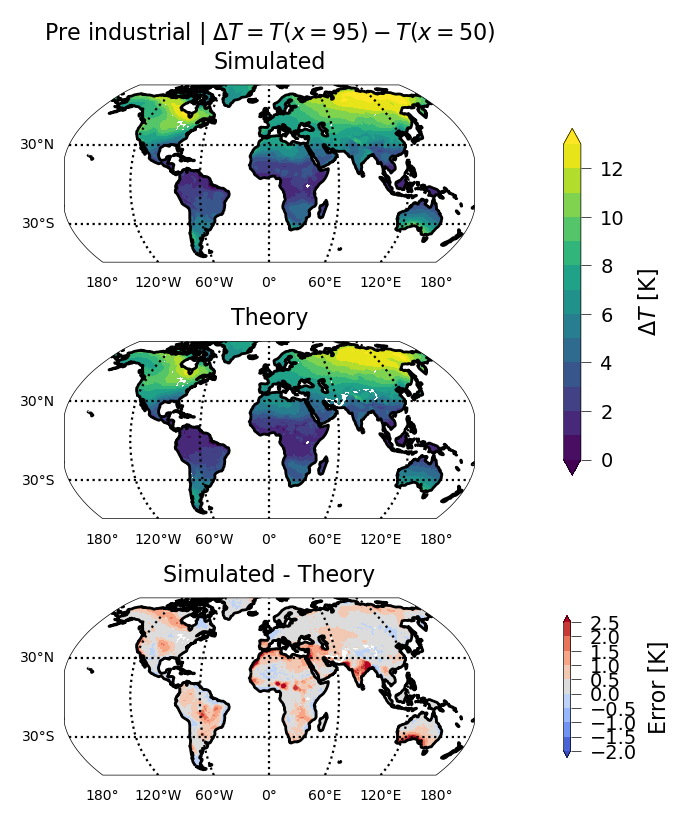

In [350]:
lat_plot_min = -60
lat_plot_max = 80
# norm_by_av = 'FT'
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0, 14, 1)
plot_contour_projection(ax[0], TREFHT_anom.isel(co2=co2_ind),
                        cmap='viridis', levels=levels_use)
im = plot_contour_projection(ax[1], TREFHT_anom_theory.isel(co2=co2_ind), cmap='viridis', levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2], TREFHT_anom.isel(co2=co2_ind) - TREFHT_anom_theory.isel(co2=co2_ind),
                             cmap='coolwarm', levels=np.arange(-2, 3, 0.5))
# im = plot_contour_projection(ax[1], var_theory,
#                              levels=levels_temp_change[norm_by_av],
#                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'{exp_labels[0]} | $\Delta T = T(x={ds.quant[1]:.0f}) - T(x={ds.quant[0]:.0f})$\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Breakdown of mechanisms
Below, I plot the contribution from each mechanism to the anomaly in a given climate.

In [12]:
units_breakdown = {
    'change': {'p_lcl': 'Pa/Pa', 'p_s': 'Pa/Pa', 'T500': 'K', 'lapse_below_lcl': 'K/km', 'lapse_above_lcl': 'K/km'},
    'sensitivity': {'p_lcl': 'K', 'p_s': 'K', 'T500': 'K/K', 'lapse_below_lcl': 'km', 'lapse_above_lcl': 'km'}}
name_breakdown = {'T500_zonal_av': '$\overline{T_{500}}$', 'T500_anom': '$\Delta T_{500}$', 'p_lcl': '$\sigma_{LCL}$',
                  'p_s': '$\sigma_{500}$', 'lapse_below_lcl': '$\Gamma_{<LCL}$', 'lapse_above_lcl': '$\Gamma_{>LCL}$'}

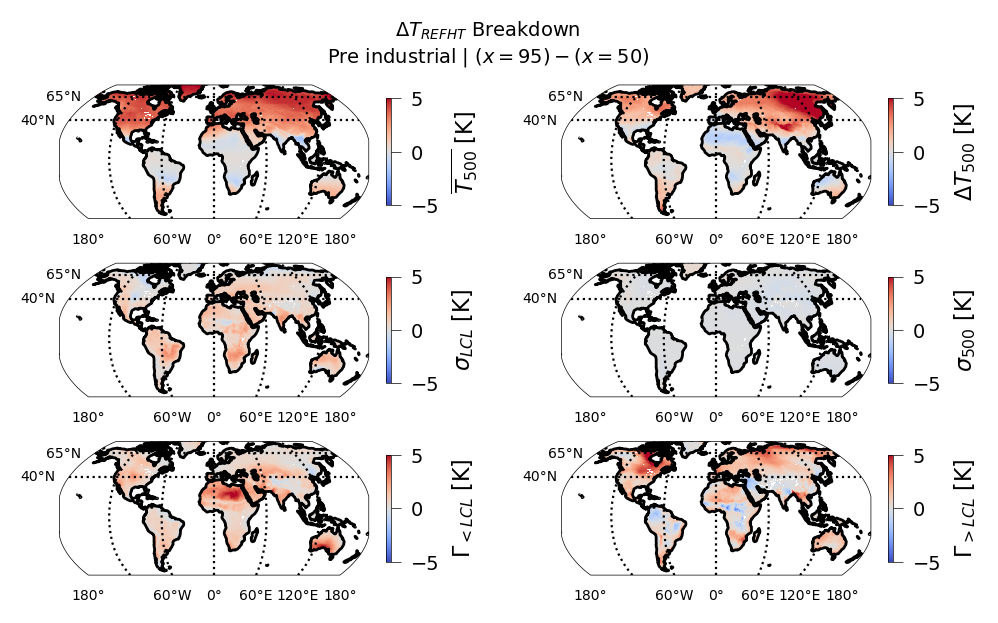

In [107]:
co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(10 / 2, len(name_breakdown) / 2))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
ax = ax.flatten()
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values,
                          TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind).where(land > 0),
                          transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-5, vmax=5)
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.suptitle(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()

### Most important mechanism
Below, I plot which mechanism is most important in setting the anomaly in a given climate.

In [61]:
TREFHT_anom_cont_abs_sum = sum([np.abs(TREFHT_anom_breakdown_cont[key]) for key in name_breakdown])
TREFHT_anom_cont_frac = [
    (np.abs(TREFHT_anom_breakdown_cont[key]).where(land > 0) / TREFHT_anom_cont_abs_sum).isel(co2=co2_ind) for key in
    name_breakdown]
TREFHT_anom_cont_frac = xr.concat(TREFHT_anom_cont_frac,
                                  dim=xr.DataArray(list(name_breakdown.keys()), name='mechanism', dims='mechanism'))

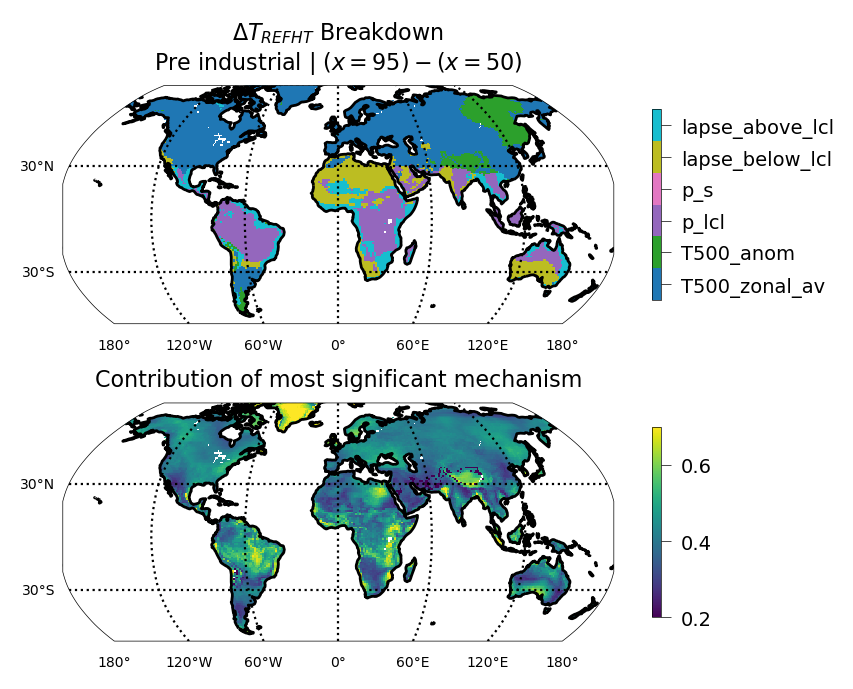

In [342]:
co2_ind = 0
mask_use = land > 0
# mask_use = TREFHT_anom_cont_frac.max(dim='mechanism')>0.35
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, 5, ar=3)
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)

cmap = plt.get_cmap('tab10', len(name_breakdown))  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(np.arange(len(name_breakdown) + 1) - 0.5, len(name_breakdown))
im = TREFHT_anom_cont_frac.fillna(0).argmax(dim='mechanism').where(mask_use).plot(ax=ax[0], cmap=cmap, norm=norm,
                                                                                  add_colorbar=False,
                                                                                  transform=ccrs.PlateCarree())
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax[0], ticks=np.arange(len(name_breakdown)), shrink=0.8)
cbar.ax.set_yticklabels(name_breakdown)
ax[0].set_title(f'$\Delta T_{"{REFHT}"}$ Breakdown\n{exp_labels[co2_ind]} | $(x={quant[1]}) - (x={quant[0]})$')

im = TREFHT_anom_cont_frac.max(dim='mechanism').where(mask_use).plot(ax=ax[1], cmap='viridis', add_colorbar=False,
                                                                     transform=ccrs.PlateCarree(), vmin=0.2, vmax=0.7)
fig.colorbar(im, ax=ax[1], shrink=0.8)
ax[1].set_title('Contribution of most significant mechanism')
# isca_tools.savefig(fig)
plt.show()

## Change in anomaly with warming
Here I look at the mechanisms causing the anomaly shown above to change with warming i.e. why does the shape of the distribution change with warming.

### Compare theory to simulated
As before, we check that the simulated change is well explained by the linear theory.

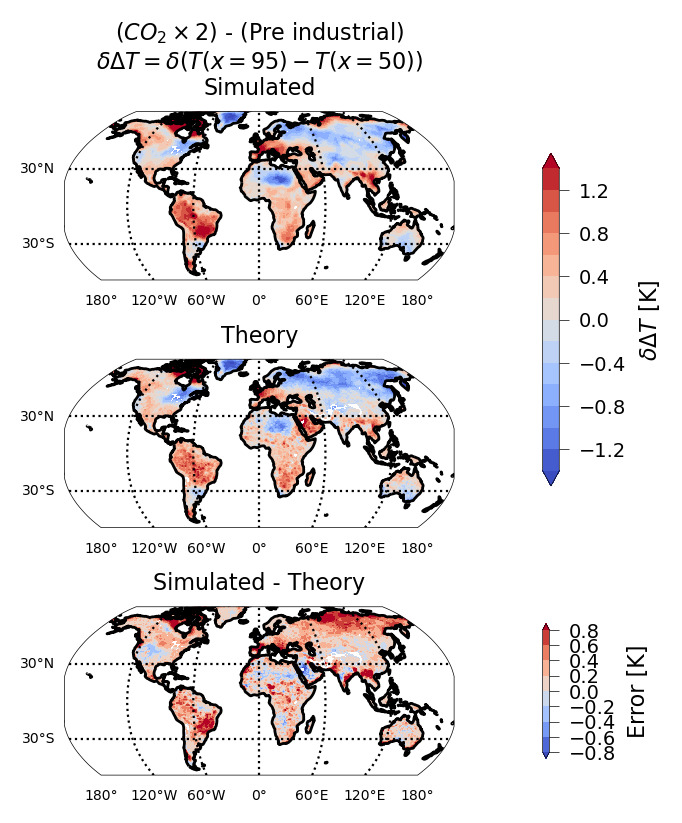

In [351]:
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)

levels_use = np.arange(0, 14, 1)
plot_contour_projection(ax[0], TREFHT_anom.isel(co2=1) - TREFHT_anom.isel(co2=0),
                        cmap='coolwarm', levels=np.arange(-1.4, 1.6, 0.2))
im = plot_contour_projection(ax[1], TREFHT_anom_theory.isel(co2=1) - TREFHT_anom_theory.isel(co2=0), cmap='coolwarm',
                             levels=np.arange(-1.4, 1.6, 0.2))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\delta \Delta T$ [K]', mappable=im)
im = plot_contour_projection(ax[2], TREFHT_anom.isel(co2=1) - TREFHT_anom.isel(co2=0) -
                             (TREFHT_anom_theory.isel(co2=1) - TREFHT_anom_theory.isel(co2=0)),
                             cmap='coolwarm', levels=np.arange(-0.8, 1, 0.2))
# im = plot_contour_projection(ax[1], var_theory,
#                              levels=levels_temp_change[norm_by_av],
#                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(
    f'({exp_labels[1]}) - ({exp_labels[0]})\n$\delta \Delta T = \delta (T(x={ds.quant[1]:.0f}) - T(x={ds.quant[0]:.0f}))$\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Breakdown of mechanisms
Below, I plot the contribution from each mechanism to the change in anomaly with warming.

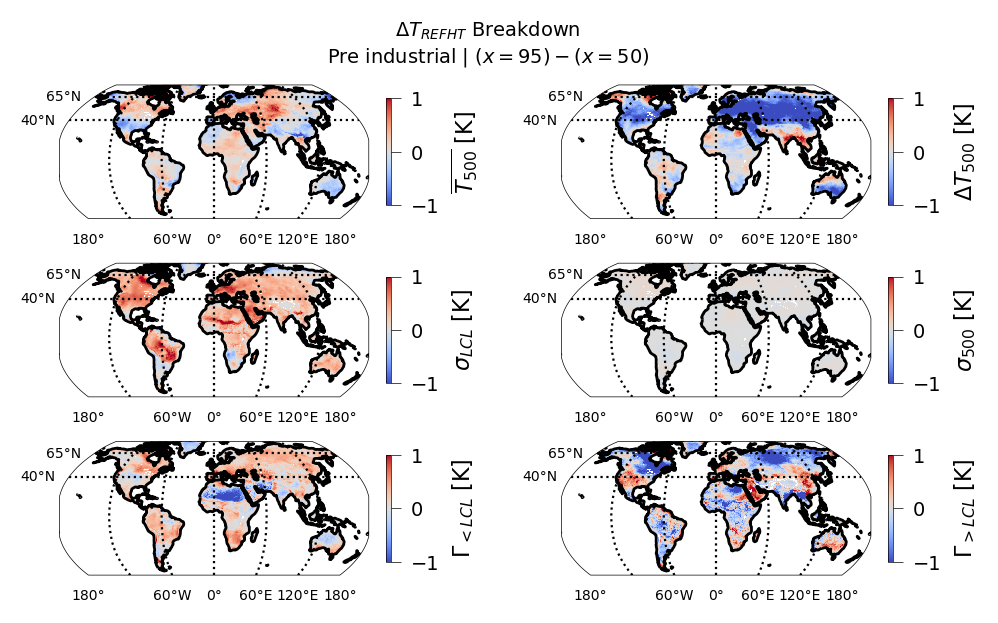

In [120]:
fig = plt.figure(constrained_layout=True, figsize=(10 / 2, len(name_breakdown) / 2))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
ax = ax.flatten()
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values,
                          (TREFHT_anom_breakdown_cont[key].isel(co2=1) - TREFHT_anom_breakdown_cont[key].isel(
                              co2=0)).where(land > 0),
                          transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1, vmax=1)
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.suptitle(
    f'$\delta \Delta T_{"{REFHT}"}$ Breakdown\n({exp_labels[1]}) - ({exp_labels[0]}) | $(x={quant[1]}) - (x={quant[0]})$')
plt.show()

### Most important mechanism
Below, I plot which mechanism is most important in changing the anomaly with warming.

In [124]:
TREFHT_anom_change_cont_abs_sum = sum(
    [np.abs(TREFHT_anom_breakdown_cont[key].isel(co2=1) - TREFHT_anom_breakdown_cont[key].isel(co2=0))
     for key in name_breakdown])
TREFHT_anom_change_cont_frac = [(np.abs(TREFHT_anom_breakdown_cont[key].isel(co2=1) -
                                        TREFHT_anom_breakdown_cont[key].isel(co2=0)).where(
    land > 0) / TREFHT_anom_change_cont_abs_sum)
                                for key in name_breakdown]
TREFHT_anom_change_cont_frac = xr.concat(TREFHT_anom_change_cont_frac,
                                         dim=xr.DataArray(list(name_breakdown.keys()), name='mechanism',
                                                          dims='mechanism'))

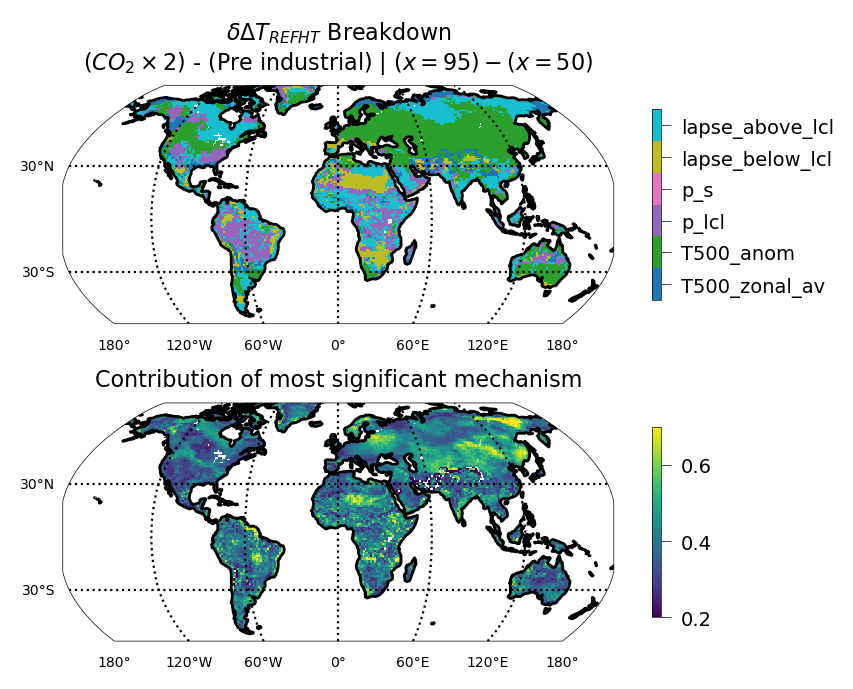

In [343]:
mask_use = land > 0
# mask_use = TREFHT_anom_change_cont_frac.max(dim='mechanism')>0.35
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, 5, ar=3)
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)

cmap = plt.get_cmap('tab10', len(name_breakdown))  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(np.arange(len(name_breakdown) + 1) - 0.5, len(name_breakdown))
im = TREFHT_anom_change_cont_frac.fillna(0).argmax(dim='mechanism').where(mask_use).plot(ax=ax[0], cmap=cmap, norm=norm,
                                                                                         add_colorbar=False,
                                                                                         transform=ccrs.PlateCarree())
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax[0], ticks=np.arange(len(name_breakdown)), shrink=0.8)
cbar.ax.set_yticklabels(name_breakdown)
ax[0].set_title(
    f'$\delta \Delta T_{"{REFHT}"}$ Breakdown\n({exp_labels[1]}) - ({exp_labels[0]}) | $(x={quant[1]}) - (x={quant[0]})$')

im = TREFHT_anom_change_cont_frac.max(dim='mechanism').where(mask_use).plot(ax=ax[1], cmap='viridis',
                                                                            add_colorbar=False,
                                                                            transform=ccrs.PlateCarree(), vmin=0.2,
                                                                            vmax=0.7)
fig.colorbar(im, ax=ax[1], shrink=0.8)
ax[1].set_title('Contribution of most significant mechanism')
# isca_tools.savefig(fig)
plt.show()

## Change of given percentile relative to spatial average
This considers the change with warming above a given percentile, and explains why there is a spatial variation in this. As the spatial average, I take the rolling average in window of 10$\degree$ in latitude.
### Compare theory to simulated
As before, we check that the simulated change is well explained by the linear theory.

In [217]:
quant_ind = 1
TREFHT_change_breakdown_change = {'T500': ds.T.isel(quant=quant_ind, co2=1) - ds.T.isel(quant=quant_ind, co2=0),
                                  'lapse_below_lcl': ds.lapse_below_lcl.isel(quant=quant_ind,
                                                                             co2=1) - ds.lapse_below_lcl.isel(
                                      quant=quant_ind, co2=0),
                                  'lapse_above_lcl': ds.lapse_above_lcl.isel(quant=quant_ind,
                                                                             co2=1) - ds.lapse_above_lcl.isel(
                                      quant=quant_ind, co2=0),
                                  'p_lcl': (ds.p_lcl / ds.PREFHT).isel(quant=quant_ind, co2=1) - (
                                          ds.p_lcl / ds.PREFHT).isel(quant=quant_ind, co2=0),
                                  'p_s': (ds.plev / ds.PREFHT).isel(quant=quant_ind, co2=1) - (
                                          ds.plev / ds.PREFHT).isel(quant=quant_ind, co2=0)}
TREFHT_change_breakdown_sensitivity = {'T500': (ds.TREFHT / ds.T).isel(quant=quant_ind, co2=0),
                                       'lapse_below_lcl': -(ds.TREFHT * np.log(ds.p_lcl / ds.PREFHT)).isel(
                                           quant=quant_ind, co2=0) * R / g / 1000,
                                       'lapse_above_lcl': (ds.TREFHT * np.log(ds.p_lcl / ds.plev)).isel(quant=quant_ind,
                                                                                                        co2=0) * R / g / 1000,
                                       'p_lcl': R / g * ((ds.lapse_above_lcl - ds.lapse_below_lcl) / 1000 *
                                                         ds.PREFHT / ds.p_lcl * ds.TREFHT).isel(quant=quant_ind, co2=0),
                                       'p_s': -R / g * (
                                               ds.lapse_above_lcl / 1000 * ds.PREFHT / ds.plev * ds.TREFHT).isel(
                                           quant=quant_ind, co2=0)}
TREFHT_change_breakdown_cont = {key: TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]
                                for key in TREFHT_change_breakdown_change}
TREFHT_change_theory = sum(TREFHT_change_breakdown_cont.values())
TREFHT_change = ds.TREFHT.isel(quant=quant_ind, co2=1) - ds.TREFHT.isel(quant=quant_ind, co2=0)

# Add T_ft breakdown
TREFHT_change_breakdown_change['T500_zonal_av'] = ds.T_zonal_av.isel(quant=quant_ind, co2=1) - ds.T_zonal_av.isel(
    quant=0, co2=0)
TREFHT_change_breakdown_change['T500_anom'] = ds.T_anom.isel(quant=quant_ind, co2=1) - ds.T_anom.isel(quant=quant_ind,
                                                                                                      co2=0)
for key in ['T500_zonal_av', 'T500_anom']:
    TREFHT_change_breakdown_sensitivity[key] = TREFHT_change_breakdown_sensitivity['T500']
    TREFHT_change_breakdown_cont[key] = TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]

In [345]:
lat_tropics = 30
mask_av_window = (land > 0).where(land.lat > lat_plot_min).where(land.lat < lat_plot_max)
mask_av_window = mask_av_window > 0


def get_var_anom(var, n_lat_av=30, mask=mask_av_window):
    # rolling average over n_lat_av latitude coordinates
    var_mean = var.where(mask).median(dim='lon').rolling(lat=n_lat_av, center=True).median()
    return var - var_mean
    # lat_tropics = 30
    # mean_tropics = var.where(np.abs(var.lat)<=lat_trop).where(mask).median(dim=['lat', 'lon'])
    # mean_elsewhere = var.where(np.abs(var.lat)>lat_trop).where(mask).median(dim=['lat', 'lon'])
    # return var - (var*0+mean_tropics).isel(lon=0).where(np.abs(var.lat)<=lat_trop, mean_elsewhere)

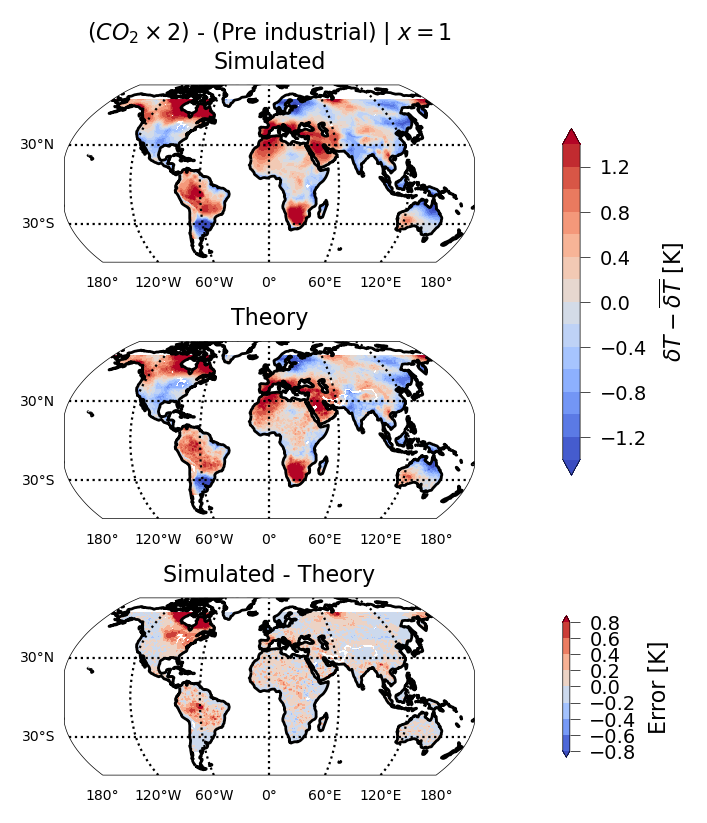

In [352]:
fig = plt.figure(constrained_layout=True, figsize=(10., 4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])

levels_use = np.arange(0, 14, 1)
plot_contour_projection(ax[0], get_var_anom(TREFHT_change),
                        cmap='coolwarm', levels=np.arange(-1.4, 1.6, 0.2))
im = plot_contour_projection(ax[1], get_var_anom(TREFHT_change_theory), cmap='coolwarm',
                             levels=np.arange(-1.4, 1.6, 0.2))
fig.colorbar(shrink=0.8, ax=ax[:2], label='$\delta T - \overline{\delta T}$ [K]', mappable=im)
im = plot_contour_projection(ax[2], get_var_anom(TREFHT_change) - get_var_anom(TREFHT_change_theory),
                             cmap='coolwarm', levels=np.arange(-0.8, 1, 0.2))
# im = plot_contour_projection(ax[1], var_theory,
#                              levels=levels_temp_change[norm_by_av],
#                              cmap='coolwarm' if norm_by_av else 'viridis')
ax[0].set_title(f'({exp_labels[1]}) - ({exp_labels[0]}) | $x={quant[quant_ind]}$\nSimulated')
ax[1].set_title('Theory')
ax[2].set_title('Simulated - Theory')
fig.colorbar(shrink=0.8, ax=ax[2], label='Error [K]', mappable=im)
# isca_tools.savefig(fig)
plt.show()

### Breakdown of mechanisms
Below, I plot the contribution from each mechanism to the change with warming.

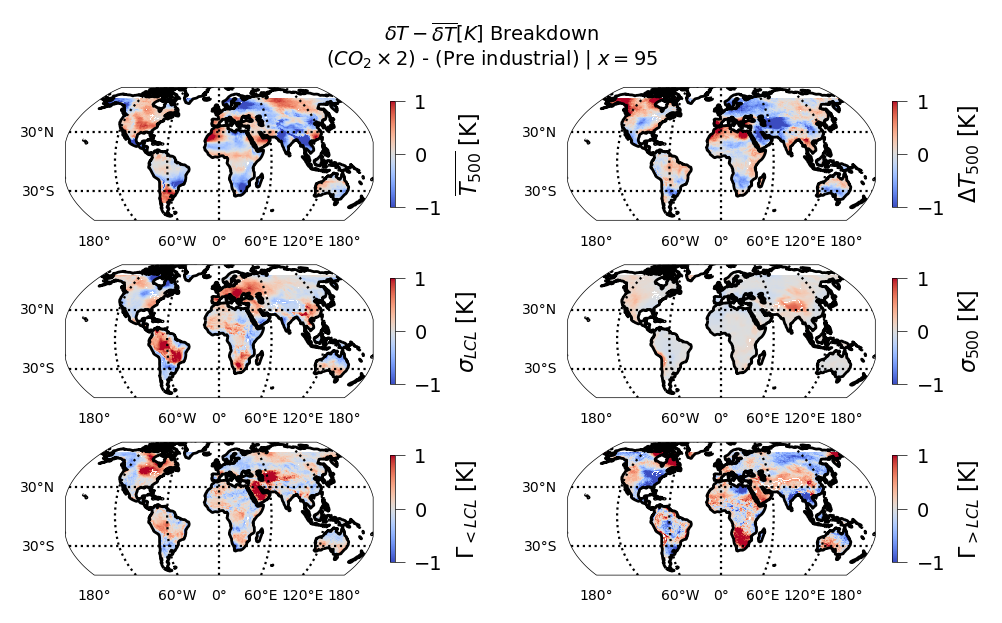

In [347]:
fig = plt.figure(constrained_layout=True, figsize=(10 / 2, len(name_breakdown) / 2))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
ax = ax.flatten()
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
    im = ax[i].pcolormesh(ds.lon.values, ds.lat.values, get_var_anom(TREFHT_change_breakdown_cont[key]).where(land > 0),
                          transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1, vmax=1)
    # im = plot_contour_projection(ax[i], TREFHT_anom_breakdown_cont[key].isel(co2=co2_ind),
    #                              cmap='coolwarm', levels=np.arange(-15, 20, 2.5))
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
fig.suptitle(
    '$\delta T - \overline{\delta T} [K]$ Breakdown\n' + f'({exp_labels[1]}) - ({exp_labels[0]}) | $x={quant[quant_ind]}$')
# isca_tools.savefig(fig)
plt.show()

### Most important mechanism
Below, I plot which mechanism is most important in changing the anomaly with warming.

In [348]:
TREFHT_change_cont_abs_sum = sum([np.abs(get_var_anom(TREFHT_change_breakdown_cont[key]))
                                  for key in name_breakdown])
TREFHT_change_cont_frac = [
    (np.abs(get_var_anom(TREFHT_change_breakdown_cont[key])).where(land > 0) / TREFHT_change_cont_abs_sum)
    for key in name_breakdown]
TREFHT_change_cont_frac = xr.concat(TREFHT_change_cont_frac,
                                    dim=xr.DataArray(list(name_breakdown.keys()), name='mechanism', dims='mechanism'))

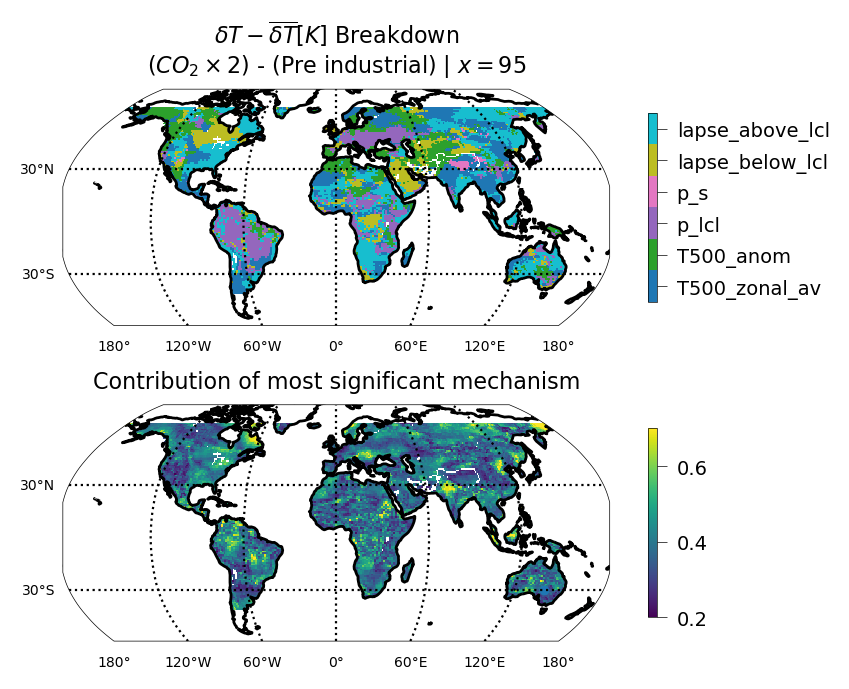

In [356]:
mask_use = land > 0
mask_use = TREFHT_change_cont_frac.max(dim='mechanism').where(
    mask_use) > 0  # so avoid polar regions where can't average over 30 lat points
# mask_use = TREFHT_anom_change_cont_frac.max(dim='mechanism')>0.35
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, 5, ar=3)
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max, grid_lat=[-lat_tropics, lat_tropics])

cmap = plt.get_cmap('tab10', len(name_breakdown))  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(np.arange(len(name_breakdown) + 1) - 0.5, len(name_breakdown))
im = TREFHT_change_cont_frac.fillna(0).argmax(dim='mechanism').where(mask_use).plot(ax=ax[0], cmap=cmap, norm=norm,
                                                                                    add_colorbar=False,
                                                                                    transform=ccrs.PlateCarree())
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax[0], ticks=np.arange(len(name_breakdown)), shrink=0.8)
cbar.ax.set_yticklabels(name_breakdown)
ax[0].set_title(
    '$\delta T - \overline{\delta T} [K]$ Breakdown\n' + f'({exp_labels[1]}) - ({exp_labels[0]}) | $x={quant[quant_ind]}$')

im = TREFHT_change_cont_frac.max(dim='mechanism').where(mask_use).plot(ax=ax[1], cmap='viridis', add_colorbar=False,
                                                                       transform=ccrs.PlateCarree(), vmin=0.2, vmax=0.7)
fig.colorbar(im, ax=ax[1], shrink=0.8)
ax[1].set_title('Contribution of most significant mechanism')
ax[1].scatter(140, -30, transform=ccrs.PlateCarree())
plt.show()
# isca_tools.savefig(fig)

### Example profiles
Playing around with example temperature profiles

In [433]:
ds_prof = [xr.merge([xr.open_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2").sel(quant=quant)[['T']],
                     xr.open_dataset(f"{exp_path_prof}/Z/{exp_name[i]}/output.nd2").sel(quant=quant)[['Z3']]]) for i in
           range(n_exp)]
ds_prof = xr.concat(ds_prof,
                    dim=xr.DataArray([get_co2_multiplier(exp_name[i]) for i in range(n_exp)], name='co2', dims='co2'))

In [539]:
lat_plot_use = 50
lon_plot_use = 30
ds_use = ds_prof.sel(lat=lat_plot_use, lon=lon_plot_use, method='nearest').isel(lev=slice(0, surf_model_level + 1))
for key in ['Z3', 'T', 'T_zonal_av', 'Z3_lcl']:
    ds_use[key + ('' if 'lcl' in key else '_ft')] = ds.sel(lat=lat_plot_use, lon=lon_plot_use, method='nearest')[key]

(0.0, 25000.0)

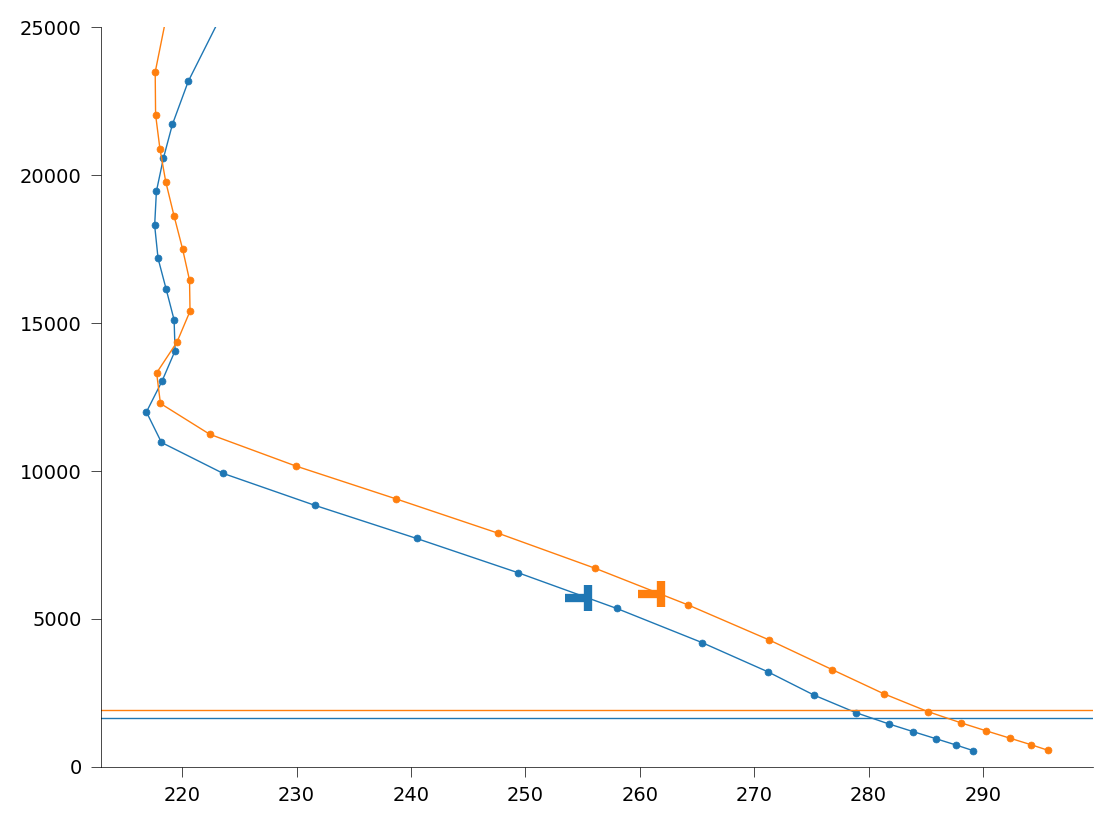

In [540]:
quant_ind_plot = 0
for i in range(2):
    plt.plot(ds_use.T.isel(co2=i, quant=quant_ind_plot), ds_use.Z3.isel(co2=i, quant=quant_ind_plot), marker='.',
             markersize=5, color=f'C{i}')
    plt.axhline(ds_use.Z3_lcl.isel(quant=quant_ind_plot, co2=i), color=f'C{i}')
    plt.scatter(ds_use.T_zonal_av_ft.isel(quant=quant_ind_plot, co2=i), ds_use.Z3_ft.isel(quant=quant_ind_plot, co2=i),
                color=f'C{i}',
                marker='_', s=90, lw=3)
    plt.scatter(ds_use.T_ft.isel(quant=quant_ind_plot, co2=i), ds_use.Z3_ft.isel(quant=quant_ind_plot, co2=i),
                color=f'C{i}',
                marker='|', s=90, lw=3)
plt.ylim(0, 25000)
# ds.sel(lat=-30, lon=140, co2=1, method='nearest')
# plt.axhline(ds.sel(lat=-30, lon=140, co2=2, quant=50, method='nearest').Z3_lcl)
# plt.axhline(ds.sel(lat=-30, lon=140, co2=2, quant=95, method='nearest').Z3_lcl, color='C1')

In [506]:
lapse_moist(275, 1000 * 100) * 1000

6.240594788204206